**Each classification report belongs to previous cell, when you RUNN ALL**

**LOADING THE DATASETS**

In [ ]:

%pip install datasets
%pip install seqeval
from datasets import load_dataset, load_metric
import pandas as pd
import matplotlib.pyplot as plt
dataset = load_dataset("surrey-nlp/PLOD-CW")
training_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]
column_names = training_dataset.column_names
datasetOptional = load_dataset("surrey-nlp/PLOD-filtered")
len(datasetOptional["train"])


**TRAIN WITH DIFFERENT PROPORTIONS OF DATA**

In [ ]:
optional_dataset=datasetOptional["train"][:1]
optional_dataset_val=datasetOptional["validation"][:1]

In [11]:

optional_dataset=datasetOptional["train"][:25000]
optional_dataset_val=datasetOptional["validation"][:10000]


In [12]:
optional_dataset=datasetOptional["train"][:10000]
optional_dataset_val=datasetOptional["validation"][:5000]

In [13]:
optional_dataset=datasetOptional["train"][:5000]
optional_dataset_val=datasetOptional["validation"][:2500]

In [15]:


mapping = {0: "B-O", 1: "B-AC", 3: "B-LF", 4:"I-LF"}

# Apply mapping to all lists in optional_dataset['ner_tags']
mapped_ner_tags = [[mapping.get(tag, tag) for tag in ner_tags] for ner_tags in optional_dataset['ner_tags']]
mapping = {0: "B-O", 1: "B-AC", 3: "B-LF", 4:"I-LF"}

mapped_ner_tags_val = [[mapping.get(tag, tag) for tag in ner_tags] for ner_tags in optional_dataset_val['ner_tags']]
mapping = {0: "B-O", 1: "B-AC", 3: "B-LF", 4:"I-LF"}


sentences_optional=optional_dataset['tokens']
sentences_optional_val=optional_dataset_val['tokens']
# Apply mapping to all lists in optional_dataset['ner_tags']
#mapped_ner_tags2 = [[mapping.get(tag, tag) for tag in ner_tags] for ner_tags in optional_dataset2['ner_tags']]

In [16]:
print(sentences_optional[:3])

[['Alternatively', ',', 'fibroblasts', 'were', 'plated', 'sparsely', 'so', 'that', 'they', 'did', 'not', 'touch', 'each', 'other', 'and', 'induced', 'into', 'quiescence', 'by', 'serum', 'starvation', 'and', 'monitored', 'after', '4', 'd', '(', 'serum', '-', 'starved', 'for', '4', 'd', '[', 'SS4', ']', ')', 'or', '7', 'd', '(', 'serum', '-', 'starved', 'for', '7', 'd', '[', 'SS7', ']', ')', '.']]


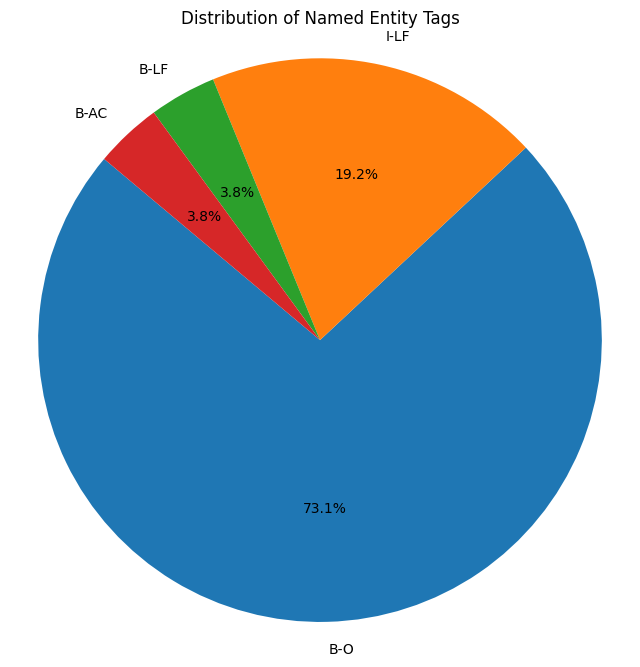

In [17]:
import matplotlib.pyplot as plt

# Count the occurrences of each named entity tag
tag_counts = {}
for sentence_tags in mapped_ner_tags:
    for tag in sentence_tags:
        tag_counts[tag] = tag_counts.get(tag, 0) + 1

# Sort the tags by count
sorted_tags = sorted(tag_counts.items(), key=lambda x: x[1], reverse=True)

# Extract tags and counts for plotting
tags = [tag for tag, count in sorted_tags]
counts = [count for tag, count in sorted_tags]

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=tags, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Named Entity Tags')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

**FETCHING THE TOKENS AND LABELS AND MAPPING THEM ACCORDINGLY**

In [ ]:

sentences_train=training_dataset['tokens']
labels_train=training_dataset['ner_tags']
pos_tags=training_dataset['pos_tags']

sentences_val=val_dataset['tokens']
labels_val=val_dataset['ner_tags']

sentences_test=test_dataset['tokens']
labels_test=test_dataset['ner_tags']



label_encoding = {"B-O": 0, "B-AC": 1, "B-LF": 2, "I-LF": 3}

label_list_train = []
for sample in labels_train:
    label_list_train.append([label_encoding[tag] for tag in sample])

label_list_test = []
for sample in labels_test:
    label_list_test.append([label_encoding[tag] for tag in sample])

label_list_val = []
for sample in labels_val:
    label_list_val.append([label_encoding[tag] for tag in sample])


label_list_opt = []
for sample in mapped_ner_tags:
    label_list_opt.append([label_encoding[tag] for tag in sample])


label_list_opt_val = []
for sample in mapped_ner_tags_val:
    label_list_opt_val.append([label_encoding[tag] for tag in sample])


In [19]:
list_for_models=[]

In [ ]:
import numpy as np
import gensim

vectorSize=200
modelFastText= gensim.models.FastText(sentences_train+sentences_optional,window=3,min_count=1,workers=4,vector_size=vectorSize)
modelFastText.train(sentences_train+sentences_optional, total_examples=len(sentences_train+sentences_optional), epochs=200)

In [21]:
padding_value=4

from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
length_padding=100;
vectorized_words_train = []
vectorized_sentence_train = []
vectorized_sentence_validation = []
vectorized_words_validation= []

for sentence in sentences_train+sentences_optional:
     vectorized_words_train= []
     for word in sentence:
            vectorized_words_train.append(modelFastText.wv[word])
     vectorized_sentence_train.append(vectorized_words_train)


for sentence in sentences_val+ sentences_optional_val:
     vectorized_words_val= []
     for word in sentence:
          if word not in modelFastText.wv.key_to_index:
            similar_word=modelFastText.wv.most_similar(word)[0][0]

            vectorized_words_val.append(modelFastText.wv[similar_word])
          else:
            vectorized_words_val.append(modelFastText.wv[word])
     vectorized_sentence_validation.append(vectorized_words_val)

padded_sentences_train= pad_sequences(vectorized_sentence_train,length_padding, padding='post', dtype='float32')
padded_labels_train = pad_sequences(label_list_train+label_list_opt, length_padding,padding='post', dtype='float32', value=padding_value)
padded_sentences_val= pad_sequences(vectorized_sentence_validation,length_padding, padding='post', dtype='float32')
padded_labels_val = pad_sequences(label_list_val+label_list_opt_val, length_padding,padding='post', dtype='float32', value=padding_value)



print(len(sentences_test))

vectorized_sentence_test= []
for sentence in sentences_test:
     vectorized_words_test= []
     for word in sentence:
            if word not in modelFastText.wv.key_to_index:
              similar_word=modelFastText.wv.most_similar(word)[0][0]

              vectorized_words_val.append(modelFastText.wv[similar_word])
            else:
              vectorized_words_test.append(modelFastText.wv[word])
     vectorized_sentence_test.append(np.array(vectorized_words_test))

print(len(vectorized_sentence_test))
padded_sentences_test= pad_sequences(vectorized_sentence_test,100, padding='post', dtype='float32')
padded_labels_test = pad_sequences(label_list_test, 100,padding='post', dtype='float32', value=4)


153
153


**TO USE LEARNING RATE WITH 0.005.**

early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True) is added it can be removed and remove from fit method


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Flatten, SimpleRNN, Masking,Conv1D, MaxPooling1D, RNN, Activation
from tensorflow.keras.optimizers import Adam, SGD, AdamW
from tensorflow.keras import layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy,CategoricalFocalCrossentropy, CategoricalCrossentropy


model= Sequential()
model.add(Masking(mask_value = 0.,input_shape=(100, vectorSize)))

model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(Dense(4,activation='softmax'))
loss = SparseCategoricalCrossentropy(
    from_logits=False,
    ignore_class=4,
    reduction="sum_over_batch_size",
    name="sparse_categorical_crossentropy",
)

optimizer = AdamW(learning_rate=0.005)

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)

model.fit(padded_sentences_train, padded_labels_train, batch_size=16, epochs=5, validation_data=(padded_sentences_val,padded_labels_val),callbacks=[early_stopping])

5/5 [==============================] - 3s 41ms/step
0.8665769589069454
0.843
              precision    recall  f1-score   support

          AC       0.24      0.09      0.13       270
          LF       0.04      0.02      0.03       152
           O       0.87      0.97      0.92      4292

   micro avg       0.85      0.89      0.87      4714
   macro avg       0.38      0.36      0.36      4714
weighted avg       0.81      0.89      0.84      4714



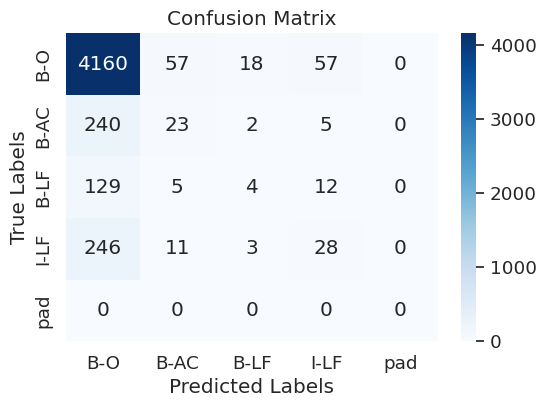

In [23]:
from seqeval.metrics import accuracy_score
from seqeval.metrics import classification_report
from seqeval.metrics import f1_score
import seaborn as sns

predicted_probabilities = model.predict(padded_sentences_test)
len(padded_sentences_test)
len(padded_labels_test)

predicted_classes = np.argmax(predicted_probabilities, axis=2)
#predicted_classes[0]
padded_labels_test[0]
predicted_classes[0]

filtered_padded_labels_test = padded_labels_test.tolist()
filtered_predicted_classes=predicted_classes.tolist()

for pred, labels in zip(filtered_predicted_classes, filtered_padded_labels_test):
    #print("Predicted Classes before removal:", pred)
    #print("Padded Labels Test before removal:", labels)

    indices_to_remove = []  # Store indices to be removed

    # Iterate over the inner list
    for i, item in enumerate(labels[:]):  # Iterating over a copy of the list to avoid issues with removal
        if item == 4:
            labels.remove(item)
            indices_to_remove.append(i)  # Store index to remove corresponding element in predicted_classes

    # Remove corresponding elements in predicted_classes
    for index in reversed(indices_to_remove):
        pred.pop(index)


label_map = {
    0: 'B-O',
    1: 'B-AC',
    2: 'B-LF',
    3: 'I-LF',
    4:'pad'


}

# Map numerical labels to string labels
predicted_classes_mapped = []
for instance in filtered_predicted_classes:
    mapped_instance = [label_map[label] for label in instance]
    predicted_classes_mapped.append(mapped_instance)


# Output the mapped predicted classes
predicted_classes_mapped[5]


padded_labels_test_mapped= []
for instance in filtered_padded_labels_test:
    mapped_instance = [label_map[label] for label in instance]
    padded_labels_test_mapped.append(mapped_instance)



# Output the mapped predicted classes


y_true = padded_labels_test_mapped
y_pred = predicted_classes_mapped

print(f1_score(y_true, y_pred, zero_division=0))


print(accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

true_labels_flat = [label for sublist in y_true for label in sublist]
predicted_labels_flat = [label for sublist in y_pred for label in sublist]

# Get unique labels
unique_labels = ['B-O','B-AC', 'B-LF', 'I-LF', 'pad']


# Initialize confusion matrix
confusion_matrix = np.zeros((len(unique_labels), len(unique_labels)), dtype=int)

# Populate confusion matrix
for true_label, predicted_label in zip(true_labels_flat, predicted_labels_flat):
    true_index = unique_labels.index(true_label)
    predicted_index = unique_labels.index(predicted_label)
    confusion_matrix[true_index][predicted_index] += 1

# Print confusion matrix

import seaborn as sns
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.2)  # Adjust font size for better readability
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

**IT IS FOR DIFFERENT BATCH SIZE=64**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Flatten, SimpleRNN, Masking,Conv1D, MaxPooling1D, RNN, Activation
from tensorflow.keras.optimizers import Adam, SGD, AdamW
from tensorflow.keras import layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy,CategoricalFocalCrossentropy, CategoricalCrossentropy


model= Sequential()
model.add(Masking(mask_value = 0.,input_shape=(100, vectorSize)))

model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(Dense(4,activation='softmax'))
loss = SparseCategoricalCrossentropy(
    from_logits=False,
    ignore_class=4,
    reduction="sum_over_batch_size",
    name="sparse_categorical_crossentropy",
)

optimizer = AdamW(learning_rate=0.005)

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)

model.fit(padded_sentences_train, padded_labels_train, batch_size=64, epochs=5, validation_data=(padded_sentences_val,padded_labels_val),callbacks=[early_stopping])

5/5 [==============================] - 3s 40ms/step
0.846955796497081
0.8236
              precision    recall  f1-score   support

          AC       0.17      0.06      0.09       270
          LF       0.02      0.03      0.03       152
           O       0.88      0.94      0.91      4292

   micro avg       0.83      0.86      0.85      4714
   macro avg       0.36      0.34      0.34      4714
weighted avg       0.81      0.86      0.83      4714



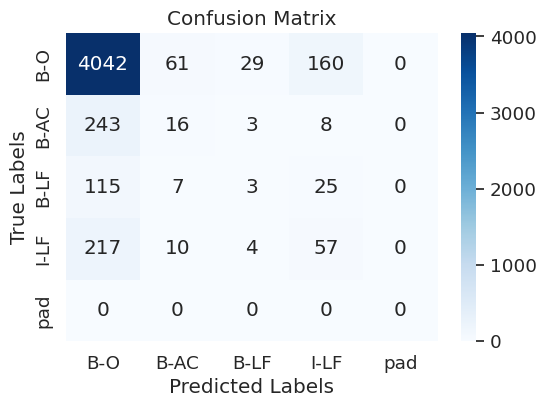

In [25]:
from seqeval.metrics import accuracy_score
from seqeval.metrics import classification_report
from seqeval.metrics import f1_score
from seqeval.metrics import accuracy_score
from seqeval.metrics import classification_report
from seqeval.metrics import f1_score



import seaborn as sns

predicted_probabilities = model.predict(padded_sentences_test)
len(padded_sentences_test)
len(padded_labels_test)

predicted_classes = np.argmax(predicted_probabilities, axis=2)
#predicted_classes[0]
padded_labels_test[0]
predicted_classes[0]

filtered_padded_labels_test = padded_labels_test.tolist()
filtered_predicted_classes=predicted_classes.tolist()

for pred, labels in zip(filtered_predicted_classes, filtered_padded_labels_test):
    #print("Predicted Classes before removal:", pred)
    #print("Padded Labels Test before removal:", labels)

    indices_to_remove = []  # Store indices to be removed

    # Iterate over the inner list
    for i, item in enumerate(labels[:]):  # Iterating over a copy of the list to avoid issues with removal
        if item == 4:
            labels.remove(item)
            indices_to_remove.append(i)  # Store index to remove corresponding element in predicted_classes

    # Remove corresponding elements in predicted_classes
    for index in reversed(indices_to_remove):
        pred.pop(index)


label_map = {
    0: 'B-O',
    1: 'B-AC',
    2: 'B-LF',
    3: 'I-LF',
    4:'pad'


}

# Map numerical labels to string labels
predicted_classes_mapped = []
for instance in filtered_predicted_classes:
    mapped_instance = [label_map[label] for label in instance]
    predicted_classes_mapped.append(mapped_instance)


# Output the mapped predicted classes
predicted_classes_mapped[5]


padded_labels_test_mapped= []
for instance in filtered_padded_labels_test:
    mapped_instance = [label_map[label] for label in instance]
    padded_labels_test_mapped.append(mapped_instance)



# Output the mapped predicted classes


y_true = padded_labels_test_mapped
y_pred = predicted_classes_mapped

print(f1_score(y_true, y_pred, zero_division=0))


print(accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

true_labels_flat = [label for sublist in y_true for label in sublist]
predicted_labels_flat = [label for sublist in y_pred for label in sublist]

# Get unique labels
unique_labels = ['B-O','B-AC', 'B-LF', 'I-LF', 'pad']


# Initialize confusion matrix
confusion_matrix = np.zeros((len(unique_labels), len(unique_labels)), dtype=int)

# Populate confusion matrix
for true_label, predicted_label in zip(true_labels_flat, predicted_labels_flat):
    true_index = unique_labels.index(true_label)
    predicted_index = unique_labels.index(predicted_label)
    confusion_matrix[true_index][predicted_index] += 1

# Print confusion matrix

import seaborn as sns
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.2)  # Adjust font size for better readability
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Flatten, SimpleRNN, Masking,Conv1D, MaxPooling1D, RNN, Activation
from tensorflow.keras.optimizers import Adam, SGD, AdamW
from tensorflow.keras import layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy,CategoricalFocalCrossentropy, CategoricalCrossentropy


model= Sequential()
model.add(Masking(mask_value = 0.,input_shape=(100, vectorSize)))

model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(Dense(4,activation='softmax'))
loss = SparseCategoricalCrossentropy(
    from_logits=False,
    ignore_class=4,
    reduction="sum_over_batch_size",
    name="sparse_categorical_crossentropy",
)

optimizer = AdamW(learning_rate=0.001)

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)

model.fit(padded_sentences_train, padded_labels_train, batch_size=16, epochs=5, validation_data=(padded_sentences_val,padded_labels_val),callbacks=[early_stopping])

Epoch 1/5
68/68 [==============================] - 22s 187ms/step - loss: 0.6658 - accuracy: 0.8079 - val_loss: 0.4572 - val_accuracy: 0.8517
Epoch 2/5
68/68 [==============================] - 9s 127ms/step - loss: 0.4489 - accuracy: 0.8409 - val_loss: 0.3532 - val_accuracy: 0.8788
Epoch 3/5
68/68 [==============================] - 8s 114ms/step - loss: 0.3669 - accuracy: 0.8624 - val_loss: 0.3219 - val_accuracy: 0.8852
Epoch 4/5
68/68 [==============================] - 9s 129ms/step - loss: 0.3328 - accuracy: 0.8709 - val_loss: 0.2954 - val_accuracy: 0.8899
Epoch 5/5
68/68 [==============================] - 9s 128ms/step - loss: 0.3087 - accuracy: 0.8794 - val_loss: 0.2935 - val_accuracy: 0.8913


5/5 [==============================] - 3s 40ms/step
0.8552987716010826
0.8318
              precision    recall  f1-score   support

          AC       0.19      0.07      0.10       270
          LF       0.02      0.02      0.02       152
           O       0.88      0.95      0.91      4292

   micro avg       0.84      0.87      0.86      4714
   macro avg       0.36      0.35      0.34      4714
weighted avg       0.81      0.87      0.84      4714



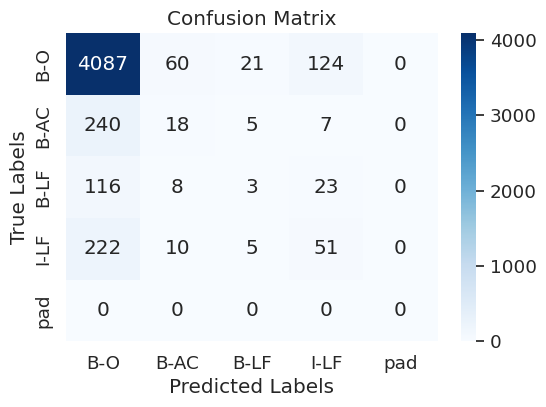

In [27]:
from seqeval.metrics import accuracy_score
from seqeval.metrics import classification_report
from seqeval.metrics import f1_score
from seqeval.metrics import accuracy_score
from seqeval.metrics import classification_report
from seqeval.metrics import f1_score



import seaborn as sns

predicted_probabilities = model.predict(padded_sentences_test)
len(padded_sentences_test)
len(padded_labels_test)

predicted_classes = np.argmax(predicted_probabilities, axis=2)
#predicted_classes[0]
padded_labels_test[0]
predicted_classes[0]

filtered_padded_labels_test = padded_labels_test.tolist()
filtered_predicted_classes=predicted_classes.tolist()

for pred, labels in zip(filtered_predicted_classes, filtered_padded_labels_test):
    #print("Predicted Classes before removal:", pred)
    #print("Padded Labels Test before removal:", labels)

    indices_to_remove = []  # Store indices to be removed

    # Iterate over the inner list
    for i, item in enumerate(labels[:]):  # Iterating over a copy of the list to avoid issues with removal
        if item == 4:
            labels.remove(item)
            indices_to_remove.append(i)  # Store index to remove corresponding element in predicted_classes

    # Remove corresponding elements in predicted_classes
    for index in reversed(indices_to_remove):
        pred.pop(index)


label_map = {
    0: 'B-O',
    1: 'B-AC',
    2: 'B-LF',
    3: 'I-LF',
    4:'pad'


}

# Map numerical labels to string labels
predicted_classes_mapped = []
for instance in filtered_predicted_classes:
    mapped_instance = [label_map[label] for label in instance]
    predicted_classes_mapped.append(mapped_instance)


# Output the mapped predicted classes
predicted_classes_mapped[5]


padded_labels_test_mapped= []
for instance in filtered_padded_labels_test:
    mapped_instance = [label_map[label] for label in instance]
    padded_labels_test_mapped.append(mapped_instance)



# Output the mapped predicted classes


y_true = padded_labels_test_mapped
y_pred = predicted_classes_mapped

print(f1_score(y_true, y_pred, zero_division=0))


print(accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

true_labels_flat = [label for sublist in y_true for label in sublist]
predicted_labels_flat = [label for sublist in y_pred for label in sublist]

# Get unique labels
unique_labels = ['B-O','B-AC', 'B-LF', 'I-LF', 'pad']


# Initialize confusion matrix
confusion_matrix = np.zeros((len(unique_labels), len(unique_labels)), dtype=int)

# Populate confusion matrix
for true_label, predicted_label in zip(true_labels_flat, predicted_labels_flat):
    true_index = unique_labels.index(true_label)
    predicted_index = unique_labels.index(predicted_label)
    confusion_matrix[true_index][predicted_index] += 1

# Print confusion matrix

import seaborn as sns
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.2)  # Adjust font size for better readability
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

**IT IS FOR DIFFERENT OPTIMIZER=ADAM**

# **Each classification report belongs to previous cell, when you RUNN ALL**